# Введение в Pytorch



Этот ноутбук - туториал по реализации пайплайна обучения и основным подмодулям Pytorch и другим полезным вещам. 

# Импорт необходимых модулей
В этом курсе я буду пользоваться Pytorch и Pytorch Geometric. Прелесть второй либы в том, что основные интерфейсы не отличаются от Pytorch. 
torch - основная либа
Импортируем torch.nn - тут находятся классы, реализующие слои, лоссы, функции ошибок и тд. 
Для примера я использую стандартный датасет для компьютерного зрения - MNIST - содержащий цифры от 0 до 9 в разном написании. Поэтому импортируются некоторые подмодули torchvision


In [112]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Compose
from matplotlib import pyplot as plt

In [113]:
import os
import pandas as pd
from torchvision.io import read_image


# Создание датасета

Pytorch позволяет использовать открытые датасеты с хаба. Они все являются подклассами `torch.utils.data.Dataset` и имплементируют методы, специфичные для этого класса данных. Обычно они используются для прототипирования и бенчмаркинга и могут быть загружены по необходимости. Однако если для задачи необзодимо что-то кроме предполагаемой разработчиками функциональности, нужно либо отнаследовать один из них, либо напрямую `torch.utils.data.Dataset`.

Давайте загрузим FashionMNIST (https://github.com/zalandoresearch/fashion-mnist) - один из таких простых бенчмарк-датасетов для компьютерного зрения. Каждый семпл - это черно-белое изображение размером 28х28 с каким-то предметом одежды и ассоциированным классом. Всего набор содержит 60000 + 10000 изображений и 10 классов.


In [114]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [115]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

In [116]:
def plot_samples(data, labels_map, cols=3, rows=3):
    figure = plt.figure(figsize=(8, 8))
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(data), size=(1,)).item()
        img, label = data[sample_idx]
        figure.add_subplot(rows, cols, i)
        if type(label) == torch.Tensor:
            plt.title(labels_map[label.item()])
        else:
            plt.title(labels_map[label])
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")
    plt.show()

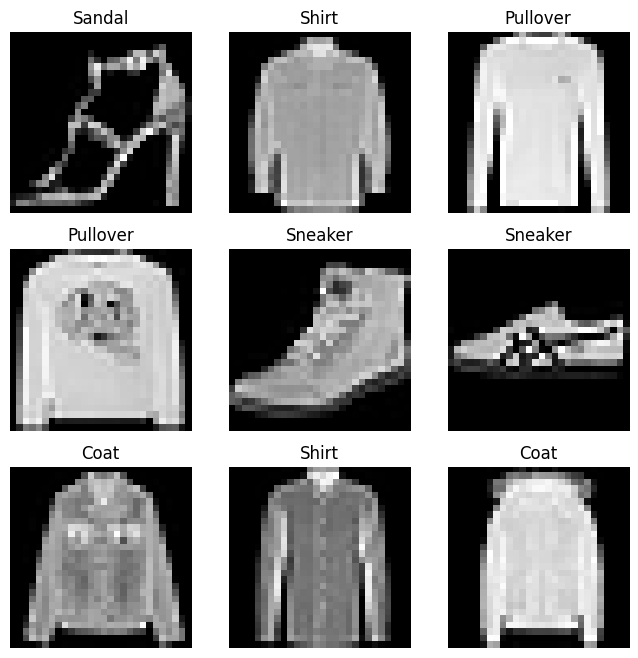

In [117]:
plot_samples(train_data, labels_map, cols=3, rows=3)

Каждый датасет в Pytorch должен наследоваться от класса Dataset и обязательно имплементировать методы `__init__, __len__, __getitem__`. В `__init__` обычно кроме прочего определяются трансформации, которые будут применяться к данным. Это может быть преобразование PIL.Image в тензоры, добавление шума, сдвиги и т.д. 
Pytorch предоставляет большое количество трансформаций, но наиболее популярная и удобная библиотека, реализующая трансформации для изображений - *albumentations*. 

`__len__` - должна возвращать размер датасета (например, чисо строк в файле с аннотациями)

`__getitem__` - должен возвращать семпл данных, например, вектор признаков и y. Однако он может возвращать еще и дополнительную информацию, например, y может состоять из набора bboxoв и  сегментационных масок для детекции, класса изображения итп. Обычно возвращается tuple. В целом, возвращаться может любая структура, которую можно представить как набор тензоров, соответствующих одному семплу и входу модели.
Внутри этого метода может происходить загрузка семпла, его трансформации и другие необходимые манипуляции. Очевидно, что он может возвращать не только изображение, но и любые другие данные, и временные ряды, и табличные данные, и облака точек, и другое. 


Давайте реализуем такой датасет для FashionMNIST. Конечно, можно было бы спокойно использовать встроенный, но так не интересно )

In [118]:
from torchvision.datasets.mnist import read_image_file, read_label_file

In [119]:
class FashionMNISTDataset(Dataset):
    def __init__(self, file_dir, train=True, transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform
        self.train = train
        image_file = f"{'train' if self.train else 't10k'}-images-idx3-ubyte"
        self.data = read_image_file(os.path.join(file_dir, image_file))

        label_file = f"{'train' if self.train else 't10k'}-labels-idx1-ubyte"
        self.targets = read_label_file(os.path.join(file_dir, label_file))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.targets[idx]
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [120]:
train_data = FashionMNISTDataset(
    file_dir="data/FashionMNIST/raw",
    train=True,
)

test_data = FashionMNISTDataset(
    file_dir="data/FashionMNIST/raw",
    train=False,
)

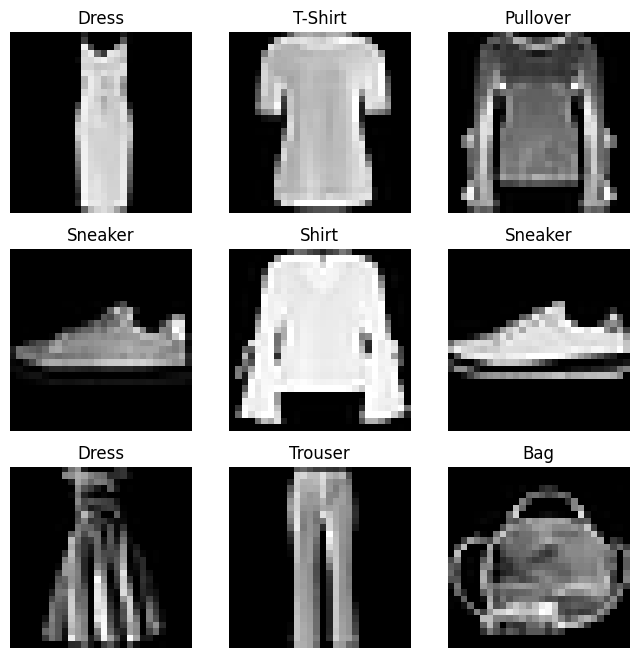

In [121]:
plot_samples(train_data, labels_map, cols=3, rows=3)

Датасет возвращает один семпл за раз, однако часто наши мощности позволяют обрабатывать больше данных. При работе с таблицами обыно модель получает на вход вообще весь набор сразу или достаточно большими порциями. Когда речь заходит о тензорах и наборах с сотнями тысяч и даже миллионами семплов, это невозможно. На помощь приходит батчевая обработка, когда из датасета берутся небольшие порции данных за раз (используя индекс). За соединение семплов во вход модели отвечает класс DataLoader. Каждую эпоху данные шаффлятся, чтобы уменьшить переобучение. 

In [122]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 28, 28])
Labels batch shape: torch.Size([64])


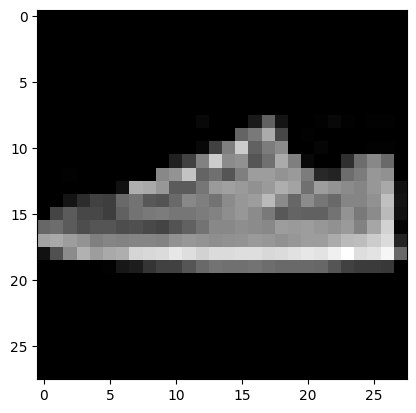

Label: 7


In [123]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze().reshape(28,28)
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

Глубокое обучение чаще всего связывают с GPU, и не зря. Имея дело с тензорами и тензорными вычислениями, мы производим огромное количество элементарных операций. Каждое ядро CPU способно произвести только одно вычисление за такт. GPU был создан для обработки графики, где требуется также большое количество простых вычислений, и поэтому может ускорить обработку данных в тысячи раз. Это все должно быть хорошо Вам известно из курсов Корхова) 

К сожалению, часто компьютер не поддерживает вычисления на GPU, например, у него просто нет дискретной видеокарты. Pytorch позволяет проводить все операции на CPU, так что его можно использовать где угодно.



In [124]:
from accelerate import Accelerator

accelerator = Accelerator()
device = accelerator.device
print(device)

mps


*Дополнительное задание: адаптируйте весь код для `accelerate`. Это очень удобная библиотека для адаптации PyTorch кода для любой распределенной конфигурации. Кроме того, она позволяет упростить работу, даже если нам нужно перенести вычисления на GPU или CPU, автоматизируя этот процесс (иначе нам нужно постоянно вызывать `.to(device)`)*

Теперь создадим класс модели и интстанциируем её. В данном случае это простой перцептрон с тремя слоями. Однако модель может быть сколько угодно сложной. Главное, чтобы она наследовала класс `nn.Module`. Более того, можно написать любой слой собственноручно, также отнаслеовав этот класс. 
Каждая модель должна имплементировать два метода - `__init__` и `forward(self, *args, **kwargs)`. В первом обычно задается ее структура и другие параметры. Модель  может даже содержать другие модели!

`forward` получает на вход Х, но он может получать несколько разных входов, маски и тд. Обычно возвращаются либо выходы с последнего слоя (один или несколько). Но, например, стандартыне модели детекции возвращают в режиме обучения значение лосса, а непосредственные предсказания только в режиме тестирования.

Вызывая `model(data)`, на самом деле мы вызываем именно метод `forward`

Обратите внимание, что PyTorch работает с тензорами, которые являются n-мерными массивами, функционально аналогичными ndarrays numpy, с дополнительной особенностью, что они могут быть использованы для вычислений на GPU. Подробнее о них можно прочитать здесь:

Для того, чтобы понять, как устроен слой в Pytorch, создадим простой слой для превращения изображения в вектор. 
Пусть это будет класс MyFlatten. Изображения (и, что более актуально, промежуточные представления или, иными словами, карты, внутри модели) изначально имеют размер N x C x H x W, где:

N - число семплов в батче
C - число каналов на входе в конкретный слой. Если вход с 3 каналами, это 3, но в середине модели это может быть любое число, например, 128.
H - высота карты
W - ширина карты

Когда мы делаем что-то вроде двумерной свертки, это стандартное представление данных, которое позволяет восстановить пространственные зависимости между элементами карты. Однако, когда мы используем полносвязные модели, каждый семпл представлен единым вектором. В простом случае больше не нужно разделять разные каналы, строки и столбцы данных. Таким образом, мы используем операцию "вытянуть в вектор", чтобы превратить значения C x H x W в представление C * H * W. 

Задание: допишите класс MyFlatten

In [125]:
class MyFlatten(nn.Module):
    def forward(self, x):
        return x.flatten(1, -1).float()

In [126]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = MyFlatten()
        self.fc = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.fc(x)
        return logits

print(model)

NeuralNetwork(
  (fc): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=512, out_features=256, bias=True)
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=256, out_features=128, bias=True)
    (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.5, inplace=False)
    (16): Linear(in_features=128, out_features=10, bias=True)
  )
)


Слои: http://pytorch.org/docs/nn.html

Активации: http://pytorch.org/docs/nn.html#non-linear-activations

Зададим функцию ошибки и оптимизатор. Функция ошибки также наследуется от torch.nn.Module и может быть стандартной, состоять как из нескольких стандартных функций или их модификаций. Большое количество функций ошибки уже реализовано в Pytorch.

Внутри каждой итерации обучения оптимизация происходит в три этапа:
Вызов optimizer.zero_grad() для обнуления градиентов параметров модели. Градиенты по умолчанию складываются; чтобы избежать двойного подсчета, мы явно обнуляем их на каждой итерации.

Получение градиентов для каждого веса с помощью loss.backward(). Подробнее об этом я расскажу на следующей лекции. 
Как только мы получили наши градиенты, остается вызвать optimizer.step(), чтобы изменить параметры в соответствии с нашим алгоритмом оптимизации. 

In [127]:
def get_SGD(model):
    return torch.optim.SGD(model.parameters(), lr=1e-3)

def get_Adam(model):
     return torch.optim.Adam(model.parameters(), lr=0.0001)

def get_Adadelta(model):
    return torch.optim.Adadelta(model.parameters(), lr=0.0001)

In [128]:
losses = [nn.CrossEntropyLoss(), nn.NLLLoss(), nn.NLLLoss2d()]

optimizers = [
    get_SGD,
    get_Adam,
    get_Adadelta,
]

Задание: 
1) Выберите как минимум еще 3 разные функции ошибки из https://pytorch.org/docs/stable/nn.html#loss-functions и обучите модель с ними
2) Выберите как минимум еще 2 оптимизатора из https://pytorch.org/docs/stable/optim.html и обучите каждую из моделей с ним

В результате у вас должна получиться таблицы с лучшими значениями лосса для каждого случая для обучения и теста. В идеале оформите их в виде pandas.DataFrame или другой таблицы с удобным выводом. На паре 13 марта обсудим, какие комбинации были лучшими, а какие худшими. 

Обучим модель. Для этого нужно описать цикл обучения и проверки модели. В наивном случае создается две функции train и validate (test), которые вызываются в цикле по эпохам. В дальнейшем, при усложнении прохода по эпохе, может появиться метод train, целый класс Trainer и т.д. Пока что реализуем наивный вариант.

In [129]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)

        # Compute prediction error
        preds = model(inputs)
        loss = loss_fn(preds, targets)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            current_batch_size = len(inputs)
            loss, current = loss.item(), (batch_idx + 1) * current_batch_size
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [130]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, num_correct = 0, 0
    running_accuracy = 0 
    total = 0 
    with torch.no_grad():
        for inputs, targets in dataloader:
            preds = model(inputs)
            test_loss += loss_fn(preds, targets).item()
            num_correct += (preds.argmax(1) == targets).type(torch.float).sum().item()
    test_loss /= num_batches
    num_correct /= size
    acc = 100*num_correct
    print(f"Test Error: \n Accuracy: {acc:>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return abs(test_loss), acc

Задание: Добавьте метрики precision и recall для проверки

In [43]:
acc_while_min_loss = 0
min_loss = 100
accurate_loss = None
accurate_optimizer = None
epochs = 10
for loss_fn in losses:
    for optimizer in optimizers:
        model, optimizer, train_dataloader, test_dataloader = accelerator.prepare(
            model,
            optimizer,
            train_dataloader,
            test_dataloader,
        )
        for t in range(epochs):
            print(f"Epoch {t+1}\n-------------------------------")
            train(train_dataloader, model, loss_fn, optimizer(model))
            loss, acc = test(test_dataloader, model, loss_fn)
        if loss < min_loss:
            acc_while_min_loss = acc
            min_loss = loss
            accurate_loss = loss_fn
            accurate_optimizer = optimizer
            accurate_model = model

print(f"The min losses {loss_fn=}, {optimizer=} - {min_loss=}, {acc_while_min_loss=}")            

Epoch 1
-------------------------------
loss: 2.376169  [   64/60000]
loss: 1.468681  [ 6464/60000]
loss: 1.058800  [12864/60000]
loss: 1.139079  [19264/60000]
loss: 0.787113  [25664/60000]
loss: 0.843381  [32064/60000]
loss: 0.796472  [38464/60000]
loss: 0.683167  [44864/60000]
loss: 0.695399  [51264/60000]
loss: 0.785303  [57664/60000]
Test Error: 
 Accuracy: 78.1%, Avg loss: 0.677383 

Epoch 2
-------------------------------
loss: 0.864784  [   64/60000]
loss: 0.574647  [ 6464/60000]
loss: 0.587338  [12864/60000]
loss: 0.572619  [19264/60000]
loss: 0.657360  [25664/60000]
loss: 0.570291  [32064/60000]
loss: 0.443213  [38464/60000]
loss: 0.582999  [44864/60000]
loss: 0.543721  [51264/60000]
loss: 0.587079  [57664/60000]
Test Error: 
 Accuracy: 81.5%, Avg loss: 0.555350 

Epoch 3
-------------------------------
loss: 0.598360  [   64/60000]
loss: 0.434227  [ 6464/60000]
loss: 0.741261  [12864/60000]
loss: 0.516260  [19264/60000]
loss: 0.470201  [25664/60000]
loss: 0.577120  [32064/600

Осталось сохранить модель для дальнейшего использования. 

In [260]:
torch.save(accurate_model.state_dict(), "best_model.pth")

Какая точность получилась? 

Задание: Перепишите датасет FashionMNISTDataset так, чтобы он возвращал вектор вместо матрицы и мою модель без слоя MyFlatten(). Запустите обучение заново. Какая точность получилась теперь?

In [142]:
class FashionMNISTDataset(Dataset):
    def __init__(self, file_dir, train=True, transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform
        self.train = train
        image_file = f"{'train' if self.train else 't10k'}-images-idx3-ubyte"
        self.data = read_image_file(os.path.join(file_dir, image_file))

        label_file = f"{'train' if self.train else 't10k'}-labels-idx1-ubyte"
        self.targets = read_label_file(os.path.join(file_dir, label_file))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.targets[idx]
        
        if self.transform:
            image = self.transform(image)
        
        if self.target_transform:
            label = self.target_transform(label)
            
        return image.flatten(0, -1).float(), label


class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        logits = self.fc(x)
        return logits

print(model)

NeuralNetwork(
  (fc): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [143]:
train_data = FashionMNISTDataset(
    file_dir="data/FashionMNIST/raw",
    train=True,
)

test_data = FashionMNISTDataset(
    file_dir="data/FashionMNIST/raw",
    train=False,
)

train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [45]:
acc_while_min_loss = 0
min_loss = 100
accurate_loss = None
accurate_optimizer = None
epochs = 10
for loss_fn in losses:
    for optimizer in optimizers:
        model, optimizer, train_dataloader, test_dataloader = accelerator.prepare(
            model,
            optimizer,
            train_dataloader,
            test_dataloader,
        )
        for t in range(epochs):
            print(f"Epoch {t+1}\n-------------------------------")
            train(train_dataloader, model, loss_fn, optimizer(model))
            loss, acc = test(test_dataloader, model, loss_fn)
        if loss < min_loss:
            acc_while_min_loss = acc
            min_loss = loss
            accurate_loss = loss_fn
            accurate_optimizer = optimizer
            accurate_model = model

print(f"The min losses {loss_fn=}, {optimizer=} - {min_loss=}, {acc_while_min_loss=}")            

Epoch 1
-------------------------------
loss: 2.319198  [   64/60000]
loss: 1.519175  [ 6464/60000]
loss: 1.122489  [12864/60000]
loss: 0.829344  [19264/60000]
loss: 0.900774  [25664/60000]
loss: 0.884610  [32064/60000]
loss: 0.880130  [38464/60000]
loss: 0.762805  [44864/60000]
loss: 0.579842  [51264/60000]
loss: 0.580557  [57664/60000]
Test Error: 
 Accuracy: 78.0%, Avg loss: 0.670259 

Epoch 2
-------------------------------
loss: 0.789046  [   64/60000]
loss: 0.860897  [ 6464/60000]
loss: 0.747140  [12864/60000]
loss: 0.636272  [19264/60000]
loss: 0.603183  [25664/60000]
loss: 0.580076  [32064/60000]
loss: 0.765607  [38464/60000]
loss: 0.733366  [44864/60000]
loss: 0.411866  [51264/60000]
loss: 0.390146  [57664/60000]
Test Error: 
 Accuracy: 81.0%, Avg loss: 0.554433 

Epoch 3
-------------------------------
loss: 0.562130  [   64/60000]
loss: 0.585519  [ 6464/60000]
loss: 0.604226  [12864/60000]
loss: 0.555615  [19264/60000]
loss: 0.495642  [25664/60000]
loss: 0.525236  [32064/600

Задание: придумайте свою собственную модель, на занятии 13 марта сравнимся, у кого получилось достичь наилучших результатов. Для этого мне нужно будет получить как вашу версию этого ноутбука, так и веса модели. 

При подборе гиперпараметров (это те параметры, которые не обучаются, например, lr) и обучении модели помните:
1. Если параметры выбраны хорошо, улучшение видно уже после нескольких сотен итераций.
2. Настраивайте гиперпараметры от грубых значений к точным: начните с тестирования большого диапазона гиперпараметров всего за несколько итераций обучения, чтобы найти комбинации параметров, которые вообще работают.
3. После того, как вы нашли несколько наборов параметров, которые, по-видимому, работают, выполните более тщательный поиск по этим параметрам. Возможно, вам придется тренировать модель большее число эпох.
4. Нужно использовать валидационный набор для поиска. Этот набор нужно выделить из тренировочного и вызывать на нем функцию test.

In [153]:
train_data = FashionMNISTDataset(
    file_dir="data/FashionMNIST/raw",
    train=True,
)

test_data = FashionMNISTDataset(
    file_dir="data/FashionMNIST/raw",
    train=False,
)

train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10),
        )

    def forward(self, x):
        logits = self.fc(x)
        return logits

In [154]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.2, momentum=0.2)    
epochs = 10
model, optimizer, train_dataloader, test_dataloader = accelerator.prepare(
    model,
    optimizer,
    train_dataloader,
    test_dataloader,
)

In [155]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    loss, acc = test(test_dataloader, model, loss_fn)

print(f"The min losses {loss_fn=}, {optimizer=} - {loss=}, {acc=}")            

Epoch 1
-------------------------------
loss: 0.069219  [   64/60000]
loss: 0.144767  [ 6464/60000]
loss: 0.144928  [12864/60000]
loss: 0.098603  [19264/60000]
loss: 0.095550  [25664/60000]
loss: 0.117936  [32064/60000]
loss: 0.100972  [38464/60000]
loss: 0.056980  [44864/60000]
loss: 0.029585  [51264/60000]
loss: 0.151361  [57664/60000]
Test Error: 
 Accuracy: 87.5%, Avg loss: 0.428134 

Epoch 2
-------------------------------
loss: 0.098034  [   64/60000]
loss: 0.151875  [ 6464/60000]
loss: 0.032457  [12864/60000]
loss: 0.083498  [19264/60000]
loss: 0.028196  [25664/60000]
loss: 0.073600  [32064/60000]
loss: 0.065717  [38464/60000]
loss: 0.095499  [44864/60000]
loss: 0.080213  [51264/60000]
loss: 0.033967  [57664/60000]
Test Error: 
 Accuracy: 89.6%, Avg loss: 0.387752 

Epoch 3
-------------------------------
loss: 0.012891  [   64/60000]
loss: 0.196331  [ 6464/60000]
loss: 0.100591  [12864/60000]
loss: 0.095754  [19264/60000]
loss: 0.047626  [25664/60000]
loss: 0.078213  [32064/600